# GAN Tutorial with PyTorch: Theory, Code, and Formulas

## Author: Andrey Vlasenko  
**Repository:** [ShortGAN](https://github.com/Vlasenko2006/ShortGAN)  
_Distributed under MIT License. No warranties. Use at your own risk._

---

## Overview

This tutorial demonstrates how Generative Adversarial Networks (GANs) work using a minimal PyTorch implementation. You'll learn the theoretical background, see relevant formulas, and get code explanations for each step.

---

## What is a GAN?

A **Generative Adversarial Network (GAN)** is a framework where two neural networks — a **Generator** and a **Discriminator** — compete:

- **Generator (G):** Tries to create data (e.g., images) that look real.
- **Discriminator (D):** Tries to distinguish real data from fake data generated by G.

The competition drives both networks to improve.

---

## Loss Functions (Formulas)

The original GAN objective, introduced by Goodfellow et al. (2014):

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log(1 - D(G(z)))]
$$

Where:
- \( G(z) \) is the generated data from noise \( z \)
- \( D(x) \) is the probability that \( x \) is real

**Binary Cross Entropy (BCE) Loss:**
$$
\text{BCE}(y, \hat{y}) = -[y \cdot \log(\hat{y}) + (1-y) \cdot \log(1-\hat{y})]
$$

- **Discriminator Loss:** Classifies real as 1, fake as 0.
- **Generator Loss:** Tries to fool discriminator (wants output to be 1).

---

## Code Walkthrough


### 1. Generator Network

#### Architecture

```python
class Generator(nn.Module):
    ...
```
- **Input:** Noise vector `z` (latent space), shape `[batch, noise_dim]`
- **Layers:** Linear → Conv → BatchNorm → ConvTranspose → Linear → Tanh
- **Output:** Fake image, shape `[batch, 1, 28, 28]` (MNIST)

#### Forward Pass

$$
G(z) = \text{Tanh}(\text{FC}_2(\text{ConvBlock}(\text{ReLU}(\text{FC}_1(z)))))
$$

---

### 2. Discriminator Network

#### Architecture

```python
class Discriminator(nn.Module):
    ...
```
- **Input:** Image, shape `[batch, 1, 28, 28]`
- **Layers:** Flatten → Linear (SpectralNorm) → LeakyReLU → Dropout → Linear → Sigmoid
- **Output:** Probability `[0,1]` that input is real

#### Spectral Normalization

Stabilizes training by constraining the Lipschitz constant of the layer:

$$
\bar{W} = \frac{W}{\sigma(W)}
$$
where $( \sigma(W))$ is the largest singular value of the weight matrix $( W )$.

---

### 3. Training Functions

#### Label Smoothing

Improves stability by softening real labels:

$$
\text{smooth}(1) = 1 - \text{smoothing} + 0.5 \times \text{smoothing}
$$

#### Pretraining the Generator

```python
def pretrain_generator(...):
    # Minimize SmoothL1 loss between generated and real images
```

#### GAN Training Loop

```python
def train_gan(...):
    # 1. Train Discriminator:
    #    - Maximize D(x) for real images
    #    - Minimize D(G(z)) for fake images
    # 2. Train Generator:
    #    - Maximize D(G(z)), i.e., fool the discriminator
```

- Add noise to real images for better generalization.
- Train generator more than discriminator for faster convergence.

---

### 4. Plotting Generated Images

```python
def plot_generated_images(generator, epoch, device, examples=10):
    # Sample noise, generate images, plot and save PNG
```

---

## Full Training Script

```python
if __name__ == "__main__":
    noise_dim = 128
    batch_size = 64
    learning_rate = 0.0002
    pretrain_epochs = 3
    gan_epochs = 3
    path = "./gan_model/"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ...
    # Data: MNIST, normalized to [-1,1]
    # Pretrain generator
    # Train GAN
```

---

## Advantages & Disadvantages

**Pros:**
- Easy installation
- Fast convergence
- Works on CPU and GPU

**Cons:**
- No warranties

---

## How to Cite

If you use this code, please cite:  
[https://github.com/Vlasenko2006/ShortGAN](https://github.com/Vlasenko2006/ShortGAN)

---

## References

- [Goodfellow et al. 2014, "Generative Adversarial Nets"](https://arxiv.org/abs/1406.2661)
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


## Helper plotting function

It plots and saves the generated handwritten numbers

In [9]:
def plot_generated_images(generator, epoch, device, examples=10):
    noise = torch.randn(examples, noise_dim).to(device)
    generated_images = generator(noise).cpu().detach()
    generated_images = generated_images.view(examples, 28, 28).numpy()
    
    plt.figure(figsize=(10, 1))
    for i in range(examples):
        plt.subplot(1, examples, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan3_generated_image_epoch_{epoch}.png")
    plt.show()


## The model

### 1. Generator Class — Code Summary

This code defines a **Generator** neural network for a GAN (Generative Adversarial Network) using PyTorch. Its job is to generate images similar to MNIST digits from random noise.

---

### Key Components

- **Input:**  
  - Takes a noise vector of size `noise_dim` (latent space), typically sampled from a normal distribution.

- **Architecture:**
  1. **Fully Connected Layer (`fc1`):**  
     - Linear transformation from `noise_dim` to 256 units, followed by ReLU activation.

  2. **Convolutional Block (`conv_block`):**  
     - Unflattens the 1D vector to a 3D tensor (1 channel, 16x16 spatial size).
     - Two convolutional layers with batch normalization and ReLU, downsampling and then upsampling (with a transposed convolution) to help synthesize spatial structure.

  3. **Fully Connected Layers (`fc2`):**  
     - Flattens the output and uses two linear layers to expand to 784 features (28x28 pixels), with a final Tanh activation to ensure output values are in the range [-1, 1].

- **Output:**  
  - Reshapes the final output to image format `[batch_size, 1, 28, 28]` (MNIST grayscale image).

---

### Forward Pass Flow

1. Pass noise through `fc1` and apply ReLU.
2. Reshape and process through convolutional block (`conv_block`).
3. Flatten, process through two more linear layers, and apply Tanh.
4. Reshape to `[batch_size, 1, 28, 28]` for image output.

---

**Summary:**  
This generator transforms random noise into realistic MNIST-style images using a combination of fully connected and (transposed) convolutional layers, with batch normalization and nonlinearities to aid in training and image quality.

In [10]:

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU()
        )

        self.conv_block = nn.Sequential(
            nn.Unflatten(1, (1, 16, 16)),  # Adjust shape based on noise_dim
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (32, 16, 16)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 8, 8)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 16, 16)
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.fc2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 512),  # Match dimensions
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()  # Better for [-1, 1] normalization
        )

    def forward(self, x):
        x = self.fc1(x)
        x = self.conv_block(x)
        x = self.fc2(x)
        return x.view(-1, 1, 28, 28)





### 2. Discriminator with Spectral Normalization — Code Summary

This code defines a **Discriminator** neural network for a GAN using PyTorch, with a focus on stabilizing training through **spectral normalization**.

### Key Components

- **Spectral Normalization Helper**
  - `spectral_norm(layer)` wraps a layer with spectral normalization.
  - **Purpose:** Constrains the Lipschitz constant of each layer, helping to stabilize GAN training and prevent the discriminator from becoming too strong.

- **Discriminator Class**
  - Inherits from `nn.Module`.
  - **Architecture:**
    - **Flatten:** Converts input images (28×28) into a 1D vector of size 784.
    - **Linear Layers:** Two fully connected layers (784→256 and 256→128), each wrapped with spectral normalization.
    - **Activations:** Uses LeakyReLU activations with a negative slope of 0.2.
    - **Dropout:** Applied after each activation for regularization (p=0.3).
    - **Output Layer:** Final linear layer reduces to a single value, passed through a sigmoid to get a probability (real vs. fake).
  - **Forward Pass:** Data flows sequentially through all layers.

### Why Spectral Normalization?

- **Stabilizes Training:** Prevents the discriminator from becoming too powerful and helps maintain a balance between generator and discriminator.
- **Improves Convergence:** Reduces the risk of mode collapse and vanishing gradients in GANs.

### Example Flow

1. Input: Batch of images (shape `[batch_size, 1, 28, 28]`)
2. Flatten → Linear (SpectralNorm) → LeakyReLU → Dropout → Linear (SpectralNorm) → LeakyReLU → Dropout → Linear → Sigmoid
3. Output: Probability for each input image (real/fake)

---
**Summary:**  
This code provides a robust discriminator architecture for GANs, leveraging spectral normalization and dropout to achieve stable and effective training.

In [11]:
# Spectral Normalization Helper Function
def spectral_norm(layer):
    return nn.utils.spectral_norm(layer)


# Define the Discriminator with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            spectral_norm(nn.Linear(784, 256)),  # Apply spectral normalization
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(256, 128)),  # Apply spectral normalization
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Training loop

This code implements the core training loop for a Generative Adversarial Network (GAN) in PyTorch, including label smoothing and optional generator pre-training.

### 1. Label Smoothing

The `smooth_labels` function applies label smoothing to real labels during discriminator training. Instead of using labels exactly equal to 1 for real samples, it slightly reduces them to help stabilize GAN training and prevent the discriminator from becoming overconfident.

**Formula:**
\[
\text{smoothed label} = \text{label} \times (1 - \text{smoothing}) + 0.5 \times \text{smoothing}
\]

---

### 2. GAN Training Loop (`train_gan`)

- **Purpose:** Alternately trains the generator and discriminator networks.
- **Discriminator Training:**
  - Adds small Gaussian noise to real images for regularization.
  - Uses smoothed labels for real images and zeros for fake images.
  - Computes loss for both real and fake batches and updates discriminator parameters.
- **Generator Training:**
  - Trains the generator multiple times per batch to encourage faster learning.
  - The generator tries to produce images that “fool” the discriminator (i.e., discriminator outputs values close to real).
- **Progress Tracking:**
  - Uses `tqdm` to display a progress bar with current losses.
  - Prints average losses per epoch.
- **Checkpointing:**
  - Every 10 epochs, saves generated images and model weights for both generator and discriminator.

---

### 3. Generator Pre-training (`pretrain_generator`)

- **Purpose:** Optionally pre-trains the generator to produce images similar to real data before adversarial training starts.
- **How:** Minimizes the Smooth L1 loss (Huber loss) between generated and real images.
- **Effect:** Helps the generator learn a good initialization, leading to faster GAN convergence.

---

**In summary:**  
This code provides robust procedures for training and pre-training GANs, using best practices like label smoothing, regularization, checkpointing, and progress monitoring.

In [12]:


# Label Smoothing for Real Labels
def smooth_labels(labels, smoothing=0.1):
    return labels * (1 - smoothing) + 0.5 * smoothing


# Train the GAN
def train_gan(generator, discriminator, g_optimizer, d_optimizer, criterion, dataloader, device, noise_dim, epochs=100, path="."):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        epoch_loss_g = 0.0
        epoch_loss_d = 0.0

        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as progress_bar:
            for real_images, _ in progress_bar:
                batch_size = real_images.size(0)
                real_images = real_images.to(device)

                # Add Gaussian noise to real images
                noisy_real_images = real_images + 0.05 * torch.randn_like(real_images)

                # Generate fake images
                noise = torch.randn(batch_size, noise_dim).to(device)
                fake_images = generator(noise)

                # Train Discriminator
                real_labels = smooth_labels(torch.ones(batch_size, 1).to(device))
                fake_labels = torch.zeros(batch_size, 1).to(device)

                d_loss_real = criterion(discriminator(noisy_real_images), real_labels)
                d_loss_fake = criterion(discriminator(fake_images.detach()), fake_labels)
                d_loss = d_loss_real + d_loss_fake

                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()

                # Train Generator (multiple times per epoch)
                for _ in range(2):  # Train the generator more frequently
                    noise = torch.randn(batch_size, noise_dim).to(device)
                    fake_images = generator(noise)
                    g_loss = criterion(discriminator(fake_images), real_labels)

                    g_optimizer.zero_grad()
                    g_loss.backward()
                    g_optimizer.step()

                # Update progress bar with losses
                epoch_loss_d += d_loss.item()
                epoch_loss_g += g_loss.item()
                progress_bar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

        # Log epoch-level progress
        print(f"Epoch {epoch+1}/{epochs} - D Loss: {epoch_loss_d/len(dataloader):.8f}, G Loss: {epoch_loss_g/len(dataloader):.4f}")

        # Save generated images and models
        if (epoch + 1) % 10 == 0:
            print(" ==== saving images ==== ")
            plot_generated_images(generator, epoch + 1, device)
            torch.save(generator.state_dict(), os.path.join(path, f"generator_epoch_{epoch+1}.pth"))
            torch.save(discriminator.state_dict(), os.path.join(path, f"discriminator_epoch_{epoch+1}.pth"))


def pretrain_generator(generator, dataloader, optimizer, criterion, device, noise_dim, epochs=20):
    generator.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        with tqdm(dataloader, desc=f"Pretraining Generator Epoch {epoch+1}/{epochs}", unit="batch") as progress_bar:
            for real_images, _ in progress_bar:
                batch_size = real_images.size(0)
                real_images = real_images.to(device)

                # Generate random noise
                noise = torch.randn(batch_size, noise_dim).to(device)

                # Generate fake images
                fake_images = generator(noise)

                # Pretraining loss (Smooth L1 between fake and real images)
                loss = criterion(fake_images, real_images)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                progress_bar.set_postfix(Loss=loss.item())

        print(f"Pretraining Generator Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(dataloader):.6f}")
      


## The driver

This code sets up and launches the training process for a Generative Adversarial Network (GAN) on the MNIST dataset using PyTorch. Here’s what each block does:

---

### 1. Hyperparameters

- `noise_dim`: Size of the input noise vector to the generator (latent space).
- `batch_size`: Number of images processed in each training batch.
- `learning_rate`: Learning rate for the optimizers.
- `pretrain_epochs`: Number of epochs for pretraining the generator.
- `gan_epochs`: Total number of adversarial training epochs.
- `path`: Directory to save model weights and generated images.
- `device`: Uses GPU if available, otherwise falls back to CPU.

---

### 2. Model Initialization

- Creates instances of `Generator` and `Discriminator` models and moves them to the appropriate device (CPU or GPU).

---

### 3. Optimizers and Loss Functions

- **Optimizers:**  
  - Uses Adam optimizer for both generator and discriminator with recommended betas for GAN stability.
  - Separate optimizer for generator pre-training (lower learning rate).
- **Loss Functions:**
  - `SmoothL1Loss` for pretraining the generator (makes generated images similar to real ones).
  - `BCELoss` (Binary Cross Entropy) for adversarial GAN training (discriminator and generator).

---

### 4. Data Preparation

- **Transform:** Converts MNIST images to tensors and normalizes them to the range [-1, 1].
- **Dataset:** Downloads the MNIST dataset (if not already present).
- **DataLoader:** Provides shuffled batches of images for training.

---

### 5. Training Workflow

1. **Generator Pretraining:**  
   Calls `pretrain_generator()` to initialize the generator to output images similar to real MNIST digits before adversarial training.

2. **GAN Training:**  
   Calls `train_gan()` to alternately train the generator and discriminator using the adversarial loss.

---

**Summary:**  
The script configures hyperparameters, loads data, initializes models and optimizers, pretrains the generator, and then trains the GAN, saving results periodically.

Pretraining the generator...


Pretraining Generator Epoch 1/3: 100%|█| 938/938 [01:12<00:00, 12.95batch/s, Los


Pretraining Generator Epoch 1/3 - Loss: 0.133545


Pretraining Generator Epoch 2/3: 100%|█| 938/938 [01:05<00:00, 14.35batch/s, Los


Pretraining Generator Epoch 2/3 - Loss: 0.128797


Pretraining Generator Epoch 3/3: 100%|█| 938/938 [01:05<00:00, 14.27batch/s, Los


Pretraining Generator Epoch 3/3 - Loss: 0.128245
Starting GAN training...


Epoch 1/20: 100%|█| 938/938 [02:22<00:00,  6.57batch/s, D_loss=1.38, G_loss=0.74


Epoch 1/20 - D Loss: 1.39008535, G Loss: 0.7162


Epoch 2/20: 100%|█| 938/938 [02:23<00:00,  6.53batch/s, D_loss=0.505, G_loss=2.0


Epoch 2/20 - D Loss: 0.99315528, G Loss: 1.3598


Epoch 3/20: 100%|█| 938/938 [02:24<00:00,  6.51batch/s, D_loss=0.702, G_loss=1.5


Epoch 3/20 - D Loss: 0.66120718, G Loss: 2.0813


Epoch 4/20: 100%|█| 938/938 [02:24<00:00,  6.49batch/s, D_loss=0.871, G_loss=1.2


Epoch 4/20 - D Loss: 0.66883199, G Loss: 2.0871


Epoch 5/20: 100%|█| 938/938 [02:22<00:00,  6.57batch/s, D_loss=1.22, G_loss=0.97


Epoch 5/20 - D Loss: 1.07800166, G Loss: 1.3007


Epoch 6/20: 100%|█| 938/938 [02:22<00:00,  6.61batch/s, D_loss=1.38, G_loss=0.76


Epoch 6/20 - D Loss: 1.36756171, G Loss: 0.7778


Epoch 7/20: 100%|█| 938/938 [02:24<00:00,  6.50batch/s, D_loss=1.38, G_loss=0.72


Epoch 7/20 - D Loss: 1.38824687, G Loss: 0.7460


Epoch 8/20: 100%|█| 938/938 [02:21<00:00,  6.62batch/s, D_loss=1.4, G_loss=0.748


Epoch 8/20 - D Loss: 1.38913286, G Loss: 0.7406


Epoch 9/20: 100%|█| 938/938 [02:22<00:00,  6.57batch/s, D_loss=1.4, G_loss=0.74]


Epoch 9/20 - D Loss: 1.38743049, G Loss: 0.7409


Epoch 10/20: 100%|█| 938/938 [02:25<00:00,  6.45batch/s, D_loss=1.38, G_loss=0.7


Epoch 10/20 - D Loss: 1.38636689, G Loss: 0.7402
 ==== saving images ==== 


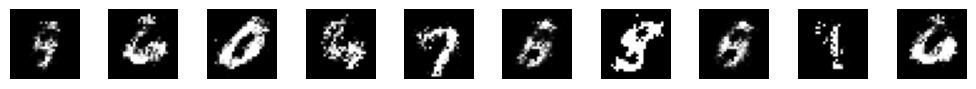

Epoch 11/20: 100%|█| 938/938 [02:23<00:00,  6.55batch/s, D_loss=1.39, G_loss=0.7


Epoch 11/20 - D Loss: 1.38610175, G Loss: 0.7408


Epoch 12/20: 100%|█| 938/938 [02:22<00:00,  6.60batch/s, D_loss=1.39, G_loss=0.7


Epoch 12/20 - D Loss: 1.38543100, G Loss: 0.7399


Epoch 13/20: 100%|█| 938/938 [02:22<00:00,  6.58batch/s, D_loss=1.39, G_loss=0.7


Epoch 13/20 - D Loss: 1.38490999, G Loss: 0.7399


Epoch 14/20: 100%|█| 938/938 [02:22<00:00,  6.57batch/s, D_loss=1.38, G_loss=0.7


Epoch 14/20 - D Loss: 1.38483955, G Loss: 0.7395


Epoch 15/20: 100%|█| 938/938 [02:25<00:00,  6.45batch/s, D_loss=1.39, G_loss=0.7


Epoch 15/20 - D Loss: 1.38456936, G Loss: 0.7396


Epoch 16/20: 100%|█| 938/938 [02:23<00:00,  6.54batch/s, D_loss=1.39, G_loss=0.7


Epoch 16/20 - D Loss: 1.38447098, G Loss: 0.7394


Epoch 17/20: 100%|█| 938/938 [02:24<00:00,  6.51batch/s, D_loss=1.38, G_loss=0.7


Epoch 17/20 - D Loss: 1.38452244, G Loss: 0.7398


Epoch 18/20: 100%|█| 938/938 [02:23<00:00,  6.56batch/s, D_loss=1.38, G_loss=0.7


Epoch 18/20 - D Loss: 1.38460482, G Loss: 0.7398


Epoch 19/20: 100%|█| 938/938 [02:22<00:00,  6.57batch/s, D_loss=1.39, G_loss=0.7


Epoch 19/20 - D Loss: 1.38444203, G Loss: 0.7395


Epoch 20/20: 100%|█| 938/938 [02:23<00:00,  6.52batch/s, D_loss=1.39, G_loss=0.7


Epoch 20/20 - D Loss: 1.38429970, G Loss: 0.7397
 ==== saving images ==== 


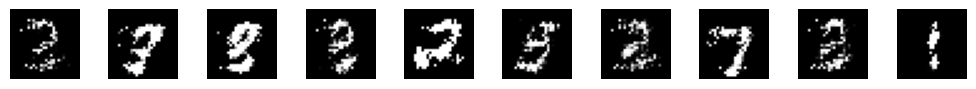

In [6]:

# Hyperparameters
noise_dim = 128
batch_size = 64
learning_rate = 0.0002
pretrain_epochs = 3  # Number of pre-training epochs
gan_epochs = 20
path = "./gan_model/"
os.makedirs(path, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers and Loss
g_pretrain_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
pretrain_criterion = nn.SmoothL1Loss()
gan_criterion = nn.BCELoss()  # Loss for GAN training

# DataLoader
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Uploads free MNIST dataset from web into ./data folder, if it is not on your computer. 
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Pretrain the generator
print("Pretraining the generator...")
pretrain_generator(generator, dataloader, g_pretrain_optimizer, pretrain_criterion, device, noise_dim, pretrain_epochs)

# Train the GAN
print("Starting GAN training...")
train_gan(generator, discriminator, g_optimizer, d_optimizer, gan_criterion, dataloader, device, noise_dim, gan_epochs, path=path)



## After 20 epochs

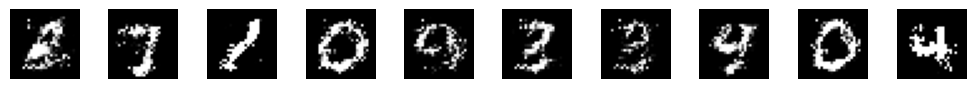

In [7]:
plot_generated_images(generator, 20, device="cpu", examples=10)